In [1]:
from __future__ import division
from pylab import rcParams
import simpy
import random
import statistics
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import pickle
import math

In [2]:
def load_market_data():
    for i in range(2, 20):
        df = pd.DataFrame()
        if(i>9):
            df = df.append(
                pd.read_csv('./data/energy_price/PUB_PriceHOEPPredispOR_20'+str(i)+'.csv', skiprows=3))
        else: 
            df = df.append(
                pd.read_csv('./data/energy_price/PUB_PriceHOEPPredispOR_200'+str(i)+'.csv', skiprows=3))
        df = clean_market_data(df)
    return df

def clean_market_data(df):
    try:
        df['HOEP'] = pd.to_numeric(df['HOEP'].str.replace(',', ''))
    except:
        #print("Already Number")
        ""
    return df

def load_data():
    return pickle.load( open( "./data/ampds.p", "rb" ) )

def weather_data():
    climate = pd.read_csv('./data/load_profile/Climate_HourlyWeather.csv')
    drop = ['Data Quality', 'Temp Flag', 'Dew Point Temp Flag', 'Wind Spd Flag', 'Stn Press Flag',
          'Hmdx Flag', 'Wind Chill Flag', 'Wind Dir Flag', 'Rel Hum Flag', 'Visibility Flag']
    climate = climate.drop(columns = drop, axis=1)
    return climate

def get_renewables():
    pv = pd.read_csv('./data/solar/Actual_44.05_-92.45_2006_DPV_20MW_5_Min.csv')
    wind = pd.read_csv('./data/wind/wind_data.csv')
    return pv, wind




In [3]:
ds = load_data()

In [4]:

print(ds['TVE'].describe()['apparent']['count'] )
print(ds['TVE'].astype(bool).sum(axis=0)['apparent'])

1051200.0
1038529


In [30]:
def get_rands_from_data(inputdata, num):

    print(inputdata)
    data = inputdata.fillna(0)
    hist, bins = np.histogram(data, bins=50)

    bin_midpoints = bins[:-1] + np.diff(bins)/2
    cdf = np.cumsum(hist)
    cdf = cdf / cdf[-1]
    values = np.random.rand(num)
    value_bins = np.searchsorted(cdf, values)
    random_from_cdf = bin_midpoints[value_bins]

    plt.subplot(121)
    plt.hist(data, 50)
    plt.subplot(122)
    plt.hist(random_from_cdf, 50)
    plt.show()
    return random_from_cdf

0        28.0
1        17.0
2        26.0
3        39.0
4        30.0
         ... 
17515    21.0
17516    14.0
17517     7.0
17518    10.0
17519     4.0
Name: Wind Spd (km/h), Length: 17520, dtype: float64


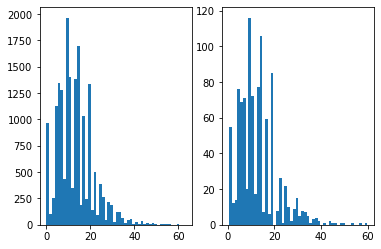

[ 4.41 10.71 17.01  9.45 14.49  8.19 19.53  4.41  6.93  1.89  9.45 19.53
  5.67  5.67 14.49 14.49  4.41 14.49 17.01  6.93 14.49 10.71  9.45  8.19
  8.19 28.35 24.57 13.23 14.49 13.23 24.57  5.67 15.75 13.23 37.17 32.13
  9.45 10.71 13.23 11.97 10.71 14.49 14.49  6.93  9.45 13.23  6.93  8.19
  5.67 13.23  3.15  0.63 29.61 10.71 37.17 17.01 13.23 14.49 22.05 13.23
  4.41  0.63  9.45 14.49  6.93 19.53  5.67 14.49  9.45 22.05 17.01 13.23
  5.67  4.41  3.15  0.63 10.71 25.83 29.61 10.71 14.49 13.23 10.71 17.01
  0.63  0.63 19.53  9.45 10.71  0.63 14.49  4.41 44.73 24.57 13.23 10.71
  9.45 22.05  1.89 14.49 10.71  9.45 14.49  4.41 29.61 28.35 19.53  8.19
 10.71 14.49 10.71 22.05 17.01  5.67 14.49  0.63 14.49 13.23  9.45  0.63
 13.23 10.71 24.57  6.93 15.75  9.45 24.57  9.45 19.53  9.45 19.53 18.27
  4.41  6.93 10.71  6.93 11.97  9.45  5.67 13.23 22.05 17.01 17.01  9.45
 13.23  9.45 14.49  9.45  6.93 10.71  5.67 10.71 15.75 14.49 24.57 19.53
 34.65  5.67 13.23 13.23 27.09  6.93 19.53  4.41 13

In [6]:
test = weather_data()
get_rands_from_data( test["Wind Spd (km/h)"], 1000)

In [36]:
# - is_controllable
# - state_connection
# - time_triggers
controllables = ['CDE', 'CWE', 'DWE', 'FGE', 'FRE', 'HPE', 'HTE']
state_connected = ['FGE', 'FRE', 'HPE', 'HTE']

for k in ds.keys():
    if 'INFO' in k:
        print(ds(k))

TypeError: 'dict' object is not callable

In [42]:
class Meter(object):

    load_distros = []
    load_infos = []

    #structure of load infos - 
    # - is_controllable
    # - state_connection
    #consumption of power by appliances on time step

    loads = []
    states = []
    state_targets = []

    net_load = 0
    #power_thresh = 200
    
    def __init__(self, json_path):
        params = json.load(open(json_path))

In [43]:
class House(object):
    
    controls = []
    
    meter = Meter('house_params.json')
    timestep = 0
    
    
    def __init__(self, env, json_path):
        self.env = env
        self.meter.meter = Meter(json_path)


    def update_state(self):
        infos = self.meter.load_infos
        for i in range(0, len(infos)):
            #state connection is in format [effect when on, effect when off], 2 numbers
            #TODO add in state initialization
            if infos[i]['state_connection'][0]>0 and self.controls[i]:
                self.meter.states[i]+=infos[i]['state_connection'][0]
            else :
                self.meter.states[i]+=infos[i]['state_connection'][1]

    def update_loads(self):
        load=0 
        infos = self.meter.load_infos
        for i in range(0, len(infos)):
            if self.controls[i]:
                tmp = get_rands_from_data(self.meter.load_distros[i], 1)[0]
                self.meter.loads[i]= tmp
                print(tmp)
        #print(self.meter.load_distros)
        #print(self.meter.loads)


    #critical loads can be treated as 1 in this scenario    
    def get_critical_load(self):
        infos = self.meter.load_infos
        crit_load = 0
        for i in range(0, len(infos)):
            if infos[i]['is_controllable'] == False:
                crit_load+=self.meter.loads[i]
                self.controls[i] = True
        return crit_load
    
    def get_control_loads(self):
        infos = self.meter.load_infos
        load = 0
        for i in range(0, len(infos)):
            if infos[i]['is_controllable']:
                load+=self.meter.loads[i]

        return load

    
    #important to call these 3 at least once before running simulation
    def set_load_distros(self, distros):
        self.meter.load_distros = distros

    def set_dur_distros(self, distros):
        self.duration_distros = distros

    #performs all functions for a typical iteration
    def run_load(self, timestep):
        #print("Next")
        self.meter.net_load = 0
        self.update_loads()
        self.meter.net_load+=self.get_critical_load()
        self.meter.net_load+=self.get_control_loads()
        #print(self.meter.load_distros)
        self.update_state()
        #print("LOAD IS"+str(self.meter.net_load))
        return self.meter.net_load


    


In [44]:
total_load =  0
timestep = 0
ren_power = 0
#replace with probabilistic model sampling
total_cost = 0

def run_grid_loads(env, loads):

    global total_load
    global timestep
    total_load= 0
    
    for l in loads:
        total_load+=l.run_load(timestep)
        #print(total_load)
    
    return total_load


weatherdata = None
winddata = None
pvdata = None
marketdata = None

def run_simulation(env, num_houses, renewable_sources, num_batteries):
    global timestep
    global weatherdata
    global winddata
    global pvdata
    global marketdata

    houses = []
    dataset = load_data()
    weatherdata = weather_data()
    pvdata, winddata = get_renewables()
    marketdata = load_market_data()

    infos = init_info(dataset, True)
    distrs = get_distrs_from_ds(dataset)
    for i in range(0, num_houses):
        h = House(env, 'house_params.json')
        h.set_load_distros(distrs)
        h.meter.infos = infos
        houses.append(h)

    while True:
        yield env.timeout(1)  # Wait a bit before generating a new round
        timestep += 1
        #print (energy_price)
        if timestep%60==0:
            update_price()
            update_weather()
        if timestep%5==0:
            update_renewables()
        run_grid_loads(env, houses)
        #print(total_load)
        get_power()

#TODO add some sophistication so that it's time-based
def get_distrs_from_ds(ds):
    distrs = []
    for key in ds.keys():
        if "INFO" not in key:
            distrs.append(ds[key]['apparent'])
    #print(distrs)
    return distrs

# - is_controllable
    # - state_connection
    # - time_triggers
#add sophistication for the special keys
def init_info(ds ,isDefault):
    infos = []
    controllables = ['CDE', 'CWE', 'DWE', 'FGE', 'FRE', 'HPE', 'HTE']
    state_connected = ['FGE', 'FRE', 'HPE', 'HTE']
    for key in ds.keys():
        if "INFO" not in key:
            tmp = ds[key+"_INFO"]
            if isDefault:
                tmp['is_controllable']= key in controllables
                tmp['state_connected'] = [0.0, 0.0]
                if key in state_connected:
                    tmp['state_connected'] = [0.01, -0.1]
            infos.append(tmp)
    return infos


def get_power():
    global ren_power
    global total_cost
    global total_load
    global pv_output
    global wind_output

    ren_power = wind_output+pv_output
    #print(ren_power)
    #would likely get renewables probabilistic cost at this time
    
    if total_load<=ren_power:
        total_cost -= (ren_power-total_load)*energy_price
    else:
        total_cost -= (ren_power-total_load)*energy_price
    
    return total_cost

market_params = {}
weather_params = {}

pv_predictions = []
pv_pred_depth = 600
pv_output = 0
wind_output = 0
wind_predictions = []
wind_pred_depth = 300
weather_predictions = []
market_predictions = []
weather_pred_depth = 10
market_pred_depth = 24

energy_price=0

def update_renewables():
    global pv_predictions
    global pv_pred_depth 
    global wind_predictions
    global wind_pred_depth
    global pv_output
    global wind_output

    global timestep
    global pvdata
    global winddata

    pv_output = pvdata['Power(MW)'].iloc[math.floor(timestep/5)]
    pv_predictions = pvdata['Power(MW)'].iloc[math.floor(timestep/5):math.floor(timestep/5)+pv_pred_depth]

    wind_output = winddata['LV ActivePower (kW)'].iloc[math.floor(timestep/10)]
    wind_predictions = winddata['LV ActivePower (kW)'].iloc[math.floor(timestep/10):math.floor(timestep/10)+wind_pred_depth]


#TODO add in some noise to the prediction "models"
#samples on every hour
def update_weather():
    global timestep
    global weather_params
    global weather_predictions
    global weatherdata

    weather_params = weatherdata.iloc[math.floor(timestep/60)]

    weather_predictions = weatherdata.iloc[math.floor(timestep/60):math.floor(timestep/60)+weather_pred_depth]
    #print(weather_params)
    
#performed every hour
def update_price():
    global timestep
    global market_params
    global energy_price
    global market_predictions
    global marketdata

    market_params = marketdata.iloc[math.floor(timestep/60)]
    energy_price = market_params['HOEP']
    market_predictions = marketdata.iloc[math.floor(timestep/60):math.floor(timestep/60)+market_pred_depth]
    #print(market_params)

def main():
    # Setup
    random.seed(42)

    # Run the simulation
    env = simpy.Environment()
    env.process(run_simulation(env, 10, 4, 1))
    #minutes to run the simulation
    env.run(until=1440)

if __name__ == '__main__':
    main()

In [6]:
update_weather()

NameError: name 'update_weather' is not defined

In [25]:
ds = load_data()

TIMESTAMP
2012-04-01 00:00:00-07:00    37.0
2012-04-01 00:01:00-07:00    37.0
2012-04-01 00:02:00-07:00    37.0
2012-04-01 00:03:00-07:00    37.0
2012-04-01 00:04:00-07:00    37.0
                             ... 
2014-03-31 23:55:00-07:00    22.0
2014-03-31 23:56:00-07:00    21.0
2014-03-31 23:57:00-07:00    22.0
2014-03-31 23:58:00-07:00    22.0
2014-03-31 23:59:00-07:00    22.0
Name: apparent, Length: 1051200, dtype: float32


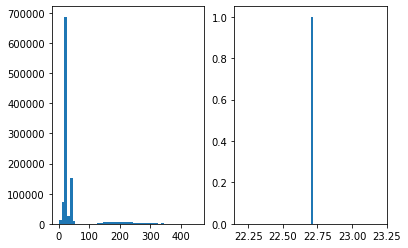

22.7

In [31]:
get_rands_from_data(ds['TVE']['apparent'], 1)[0]